
# Prediction of the KS system: a model using a 2D Convolution Neural Network

In this notebook, I will use a model of Deep Learning to predict the KS system. More precisely, we wanna predict the next step of a given history of state of the system. To do it, a simple convolutional neural network will be used.

To generate the data, I will use the KS.py code provided by Alessandro Bucci.

In [1]:
import numpy as np
import torch as th
import time
from scipy import stats
#from KS import KS
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [ ]:
#Set a javascript interval to click on the connect button every 60 seconds. 
#Open developer-settings (in your web-browser) with Ctrl+Shift+i then click 
#on console tab and type this on the console prompt.
function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,60000)

In [2]:
def drawKS(U_sim, x_axis, t_axis ,startT=0,endT=0, width = 10, divwidth = 4): 
    """
    This function will plot the evolution of the KS system (U_sim) over time (t_axis)
    
    """
    fig = plt.figure(figsize=(width, width/divwidth))
    ax = fig.gca()
    ola = ax.contourf(t_axis[startT:endT], x_axis, U_sim[startT:endT,:].T, 15)
    cbar = plt.colorbar(ola)
    plt.xlabel('Time evolution')
    plt.ylabel('Position X')
    plt.title('Spatiotemporal solution of KS equation')
    plt.show()

In [3]:
def plothist(state_history,bins=30):
    """
    plot the histogram of KS system data with the correct label
    
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    plt.hist(state_history,bins=30)
    plt.xlabel('Values of velocity')
    plt.ylabel('Frequency')
    plt.title('Histogram of state_history')
    plt.grid(True, color="#93a1a1", alpha=0.3)

In [4]:
def statvalues(state_history):
    """
    print some statistics values of the KS data
    
    """
    print('Mean:', np.mean(state_history))
    print('Median:', np.median(state_history))
    print('Max:', np.max(state_history))
    print('Min:', np.min(state_history))
    print('Mode:', stats.mode(state_history))
    print('Variance:', np.var(state_history))


In [5]:
def evolutionstat(state_history):
  """
  plot the temporal evolution of some statistics values
  
  """  
  plt.subplots(figsize=(15, 7))
  plt.subplot(2,3,1)
  plt.plot(np.mean(state_history,axis=1))
  plt.title('Mean')
  plt.ylabel('Mean value')
  plt.subplot(2,3,2)
  plt.plot(np.median(state_history,axis=1))
  plt.title('Median')
  plt.ylabel('Median value')
  plt.subplot(2,3,3)
  plt.plot(np.max(state_history,axis=1))
  plt.title('Max')
  plt.ylabel('Max value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,4)
  plt.plot(np.min(state_history,axis=1))
  plt.title('Min')
  plt.ylabel('Min value')
  plt.xlabel('Time evolution')
  plt.subplot(2,3,5)
  plt.plot(np.var(state_history,axis=1))
  plt.title('Variance')
  plt.ylabel('Variance value')
  plt.xlabel('Time evolution')

In [6]:
def prediction(model,start_position,N_step_pred,state_history_norm_th):
    """
    This function will simulate the model for a given start_position of 
    state_history_norm_th from start_position to start_position+N_step_pred
    and compares this simulation with the true value given by state_history_norm_th
    
    input:
    - model: the model that will be used to make the prediction
    - start_position: the position in the vector state_history_norm_th that will start the simulation
    - N_step_pred: number of the steps to simulate
    - state_history_norm_th: the true simulation given by KS.py. it will be used as the start point
      to initiate our model simulation and to verify the quality of this simulation
    
    
    output:
    - print: the true spatiotemporal evolution of KS system
             our simulation by the model
             the difference between them per step of the simulation
    
    state_history: all the spatialtemporal evolution of the system. shape: [number of iteractions,samples_points]
    time_counter: array of the time corresponding to each interaction
    position_x: array of samples_points points that goes from 0 to length
    """

    y_true=state_history_norm_th[start_position:start_position+N_step_pred,:].squeeze()
    sample_points=state_history_norm_th.size(1)
    current_state = th.zeros((1, 1, sample_points, size_conv_time))
    current_state[0,0,:,:] = state_history_norm_th[start_position-100:start_position,:].T
    current_state=current_state.double().cuda()
    prediction_model = th.zeros((N_step_pred, sample_points))

    for i in range(N_step_pred):
        y=model(current_state)
        past=current_state[:,:,:,1:100]
        current_state=th.zeros(1,1,64,100).double().cuda()
        current_state[:,:,:,0:99]=past
        current_state[:,:,:,99]=y
        prediction_model[i,:]=y.squeeze()


    prediction_model_np = prediction_model.detach().numpy()
    y_true_np = y_true.cpu().numpy()
    dif=np.mean(np.absolute(prediction_model_np-y_true_np),axis=1)


    print('The true solution:')
    drawKS(y_true_np, position_x, time_counter[start_position:start_position+N_step_pred] ,startT=1,endT=N_step_pred, width = 10, divwidth = 4) 
    print('The model solution:')
    drawKS(prediction_model_np, position_x,time_counter[start_position:start_position+N_step_pred] ,startT=1,endT=N_step_pred, width = 10, divwidth = 4)

    plt.plot(np.absolute(dif))
    plt.title('Difference between prediction and true value')
    plt.ylabel('Delta')
    plt.xlabel('Time step')

In [27]:
y.squeeze().shape

torch.Size([64])

## Loading and normalizing the data
First, let's set the parameters of the simulation. Pay attention to set the correct parameters to the data set loaded.

In [7]:
final_time = 10000 # the total time of the simulation
dt = 0.05 # the time step 
length = 22 # the "physical" length of the domaine. pay attention cuz this value will determine if the system is regular or chaotic
sample_points = 64 # the number of sample points on this length. It will be the size of the input in our system
#state_initial = np.loadtxt('u1.dat') #the observed initial state of the system

In [8]:
cd ..

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator


In [9]:
cd ../ks-simulator/dataset1/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\dataset1


In [10]:
#to load data

from numpy import load
# load numpy array
state_history = np.loadtxt('state_history_u3.dat')
time_counter = np.loadtxt('time_counter_u3.dat')
position_x = np.loadtxt('position_u3.dat')

print('The state_history shape is:', state_history.shape)
print('The final time:', time_counter[-1])
print('Total length', position_x[1]+position_x[-1])

The state_history shape is: (200001, 64)
The final time: 10000.0
Total length 22.0


Let's normalize the data to be between [-0.975,0.975]. It will allow us to use other activation fonction (like Tanh):

Mean: 0.0026107055720654884
Median: 0.03949771070218273
Max: 0.5814164107916223
Min: -0.538621380704021
Mode: ModeResult(mode=array([-0.53862138]), count=array([1]))
Variance: 0.10026812472997303


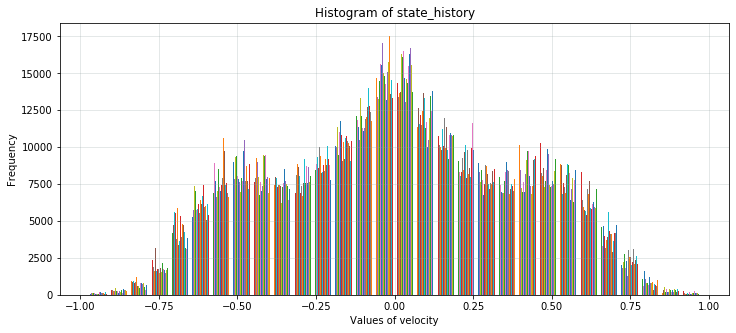

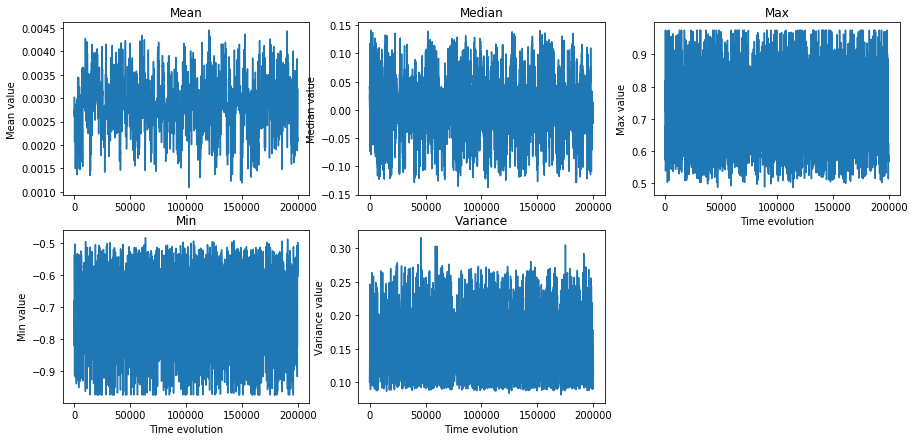

In [11]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(-0.975,0.975))
state_history_norm = min_max_scaler.fit_transform(state_history)

#histogram
plothist(state_history_norm,bins=30)

#statistic values
statvalues(state_history_norm[0,:])

#evolution of statistic values
evolutionstat(state_history_norm)

## Separating the data into training and test sets

In [ ]:
state_history_norm=state_history_norm[:100000,:]
#On google colabs, I can use up to 100,000 training points
# (this will also depend on the size of my convolution and etc.)
state_history_norm.shape

(100000, 64)

In [ ]:
size_conv_time=100
X = state_history_norm[:-size_conv_time,:] #our input: all the data excluding the last size_conv_time data
Y = state_history_norm[size_conv_time:,:] #our output: all the data minus the first size_conv_time one

NN = state_history_norm.shape[0]-2*size_conv_time
Nt = int(NN*0.9) # number of train
Nv = int(NN*0.1) # number of validation


np.random.seed(0)
indices=np.arange(NN)
np.random.shuffle(indices)
train_ind=indices[0:Nt]
valid_ind=indices[-Nv:]

X_train = np.zeros((Nt, sample_points, size_conv_time))
aux=0
for ind in train_ind:
    X_train[aux,:,:]=X[ind:ind+size_conv_time].T
    aux=aux+1

Y_train = Y[train_ind]

X_valid = np.zeros((Nv, sample_points, size_conv_time))
aux=0
for ind in valid_ind:
    X_valid[aux,:,:]=X[ind:ind+size_conv_time].T
    aux=aux+1

Y_valid = Y[valid_ind]


#converting to tensor
X_train_th = th.reshape(th.from_numpy(X_train),(Nt, 1, sample_points, size_conv_time)).cuda()
Y_train_th = th.reshape(th.from_numpy(Y_train),(Nt, sample_points)).cuda()
X_valid_th = th.reshape(th.from_numpy(X_valid),(Nv, 1, sample_points, size_conv_time)).cuda()
Y_valid_th = th.reshape(th.from_numpy(Y_valid),(Nv, sample_points)).cuda()

In [ ]:
print(X_train_th.shape)
print(Y_train_th.shape)
print(X_valid_th.shape)
print(Y_valid_th.shape)

torch.Size([89820, 1, 64, 100])
torch.Size([89820, 64])
torch.Size([9980, 1, 64, 100])
torch.Size([9980, 64])


## Training

In [ ]:
def train(model,X_train,X_valid,Y_train,Y_valid,epochs=30,batch_size=64):
    Nt=len(X_train)
    Nv=len(X_valid)
    ### Mini-batching and shuffle
    idx = np.arange(Nt)
    nbatch = int(Nt/batch_size)
    train_losses,valid_losses=[],[]
    start_time=time.time()
    print("Epoch\tTrain Loss\tValid Loss")
    
    #Just to see the prediction of our random parameters
    model.eval()
    with th.no_grad():
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
        train_losses.append(running_loss/nbatch)
        running_loss=0
        ttf_calc=model(X_valid).squeeze()
        ttf = Y_valid
        loss=loss_fn(ttf_calc,ttf)
        running_loss+=loss.item()
        valid_losses.append(running_loss)
        #it will print the result in epoch=0 during the training
    
    #starting the training here:
    for e in range(epochs):
        model.train()
        print("{}\t".format(e),"{:.5f}..\t".format(train_losses[-1]),"{:.5f}..".format(valid_losses[-1]))  
        np.random.shuffle(idx)
        running_loss=0
        for bi in range(nbatch):
            ids = idx[bi*batch_size:(bi+1)*batch_size]
            x = X_train[ids]
            optimizer.zero_grad()
            ttf_calc=model(x).squeeze()
            ttf = Y_train[ids]
            loss=loss_fn(ttf_calc,ttf)
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            
        # training is over for one epoch
        #now evaluate the model with the valid set:
        model.eval()
        accuracy=0
        train_losses.append(running_loss/nbatch)
        running_loss=0
        with th.no_grad():
            x = X_valid
            ttf_calc=model(x).squeeze()
            ttf = Y_valid
            loss=loss_fn(ttf_calc,ttf)
            running_loss+=loss.item()
            valid_losses.append(running_loss)
    print("{}\t".format(e+1),"{:.5f}..\t".format(train_losses[-1]),"{:.5f}..".format(valid_losses[-1]))     
    print("---------- Best : {:.3f}".format(min(valid_losses)), " at epoch " 
          , np.fromiter(valid_losses, dtype=np.float).argmin(), " / ",epochs )
    print('Execution time={:.2f}s'.format(time.time()-start_time))
    #plot some graphs
    plt.figure(figsize = (9, 1.5))
    ax= plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    ax.set_ylim(bottom=0)
    ax= plt.subplot(1, 2, 2)
    plt.plot(valid_losses)
    ax.set_ylim(bottom=0)
    return train_losses, valid_losses

## Model 1

In [ ]:
#CONV1
in_channel_1 = 1
Hin_ch_conv_1 = sample_points
Win_ch_conv_1 = 100

kH_conv_1 = 5
stH_conv_1 = 1
padH_conv_1 = 2

kW_conv_1 = 5
stW_conv_1 = 1
padW_conv_1 = 2

Hout_ch_conv_1 = (Hin_ch_conv_1+2*padH_conv_1-(kH_conv_1-1)-1)/stH_conv_1+1
Wout_ch_conv_1 = (Win_ch_conv_1+2*padW_conv_1-(kW_conv_1-1)-1)/stW_conv_1+1
out_channel_1 = 3


#MAXPOOL1
kH_pool_1= 2
stH_pool_1= 2

kW_pool_1= 2
stW_pool_1= 2

Hin_ch_conv_2 = (Hout_ch_conv_1 - kH_pool_1)/stH_pool_1 + 1
Win_ch_conv_2 = (Wout_ch_conv_1 - kW_pool_1)/stW_pool_1 + 1


#CONV2
in_channel_2 = out_channel_1

kH_conv_2 = 2
stH_conv_2 = 2
padH_conv_2 = 2

kW_conv_2 = 25
stW_conv_2 = 25
padW_conv_2 = 0

Hout_ch_conv_2 = (Hin_ch_conv_2+2*padH_conv_2-(kH_conv_2-1)-1)/stH_conv_2+1
Wout_ch_conv_2 = (Win_ch_conv_2+2*padW_conv_2-(kW_conv_2-1)-1)/stW_conv_2+1
out_channel_2 = 1


#MAXPOOL2

kH_pool_2= 2
stH_pool_2= 2

kW_pool_2= 2
stW_pool_2= 1

Hin_ch_conv_3 = (Hout_ch_conv_2 - kH_pool_2)/stH_pool_2 + 1
Win_ch_conv_3 = (Wout_ch_conv_2 - kW_pool_2)/stW_pool_2 + 1

in_lin = int(Hin_ch_conv_3)
out_lin = sample_points

model = th.nn.Sequential(
    th.nn.Conv2d(in_channel_1,out_channel_1,kernel_size=(kH_conv_1,kW_conv_1),stride=(stH_conv_1,stW_conv_1),padding=(padH_conv_1,padW_conv_1)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_1,kW_pool_1),stride=(stH_pool_1,stW_pool_1)),
    th.nn.Conv2d(in_channel_2,out_channel_2,kernel_size=(kH_conv_2,kW_conv_2),stride=(stH_conv_2,stW_conv_2),padding=(padH_conv_2,padW_conv_2)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_2,kW_pool_2),stride=(stH_pool_2,stW_pool_2)),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,out_lin),
    th.nn.Tanh(),
)
                   

model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

Epoch	Train Loss	Valid Loss
0	 0.19320..	 0.19215..
1	 0.18574..	 0.18165..
2	 0.17923..	 0.17395..
3	 0.17004..	 0.16433..
4	 0.16099..	 0.15582..
5	 0.15298..	 0.14823..
6	 0.14571..	 0.14127..
7	 0.13892..	 0.13468..
8	 0.13242..	 0.12831..
9	 0.12607..	 0.12204..
10	 0.11978..	 0.11582..
11	 0.11353..	 0.10961..
12	 0.10729..	 0.10344..
13	 0.10111..	 0.09736..
14	 0.09504..	 0.09141..
15	 0.08914..	 0.08563..
16	 0.08342..	 0.08008..
17	 0.07796..	 0.07480..
18	 0.07278..	 0.06981..
19	 0.06790..	 0.06514..
20	 0.06334..	 0.06078..
21	 0.05910..	 0.05672..
22	 0.05517..	 0.05299..
23	 0.05156..	 0.04956..
24	 0.04825..	 0.04643..
25	 0.04524..	 0.04358..
26	 0.04250..	 0.04099..
27	 0.04000..	 0.03863..
28	 0.03773..	 0.03649..
29	 0.03568..	 0.03455..
30	 0.03382..	 0.03278..
31	 0.03212..	 0.03118..
32	 0.03059..	 0.02973..
33	 0.02919..	 0.02842..
34	 0.02793..	 0.02721..
35	 0.02678..	 0.02612..
36	 0.02573..	 0.02512..
37	 0.02477..	 0.02421..
38	 0.02390..	 0.02337..
39	 0.0

319	 0.01014..	 0.01002..
320	 0.01013..	 0.01002..
321	 0.01013..	 0.01001..
322	 0.01012..	 0.01000..
323	 0.01011..	 0.01000..
324	 0.01011..	 0.00999..
325	 0.01010..	 0.00998..
326	 0.01009..	 0.00998..
327	 0.01009..	 0.00997..
328	 0.01008..	 0.00997..
329	 0.01008..	 0.00996..
330	 0.01007..	 0.00995..
331	 0.01006..	 0.00995..
332	 0.01006..	 0.00995..
333	 0.01005..	 0.00993..
334	 0.01005..	 0.00993..
335	 0.01004..	 0.00992..
336	 0.01004..	 0.00991..
337	 0.01003..	 0.00991..
338	 0.01002..	 0.00990..
339	 0.01002..	 0.00990..
340	 0.01001..	 0.00989..
341	 0.01000..	 0.00988..
342	 0.01000..	 0.00988..
343	 0.00999..	 0.00987..
344	 0.00999..	 0.00987..
345	 0.00998..	 0.00986..
346	 0.00997..	 0.00985..
347	 0.00997..	 0.00985..
348	 0.00996..	 0.00984..
349	 0.00996..	 0.00983..
350	 0.00995..	 0.00983..
351	 0.00994..	 0.00982..
352	 0.00994..	 0.00982..
353	 0.00993..	 0.00981..
354	 0.00993..	 0.00981..
355	 0.00992..	 0.00980..
356	 0.00991..	 0.00979..
357	 0.00991

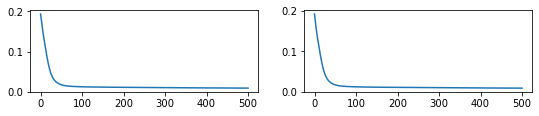

In [ ]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [ ]:
model

In [ ]:
#TO SAVE THE MODEL

# Here we create a dictionnary to store what we need: 
# 1/ the epoch number
# 2/ the batch size
# 2/ the paramters of the model
# 3/ the paramters of the optimizer
# 4/ the loss function we used
tosave_data = {'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv2d_model1_u3")

Start_position= 3000
The true solution:


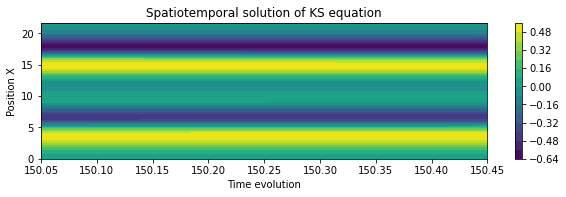

The model solution:


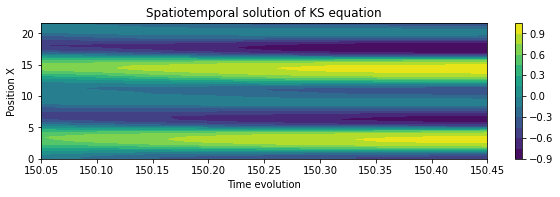

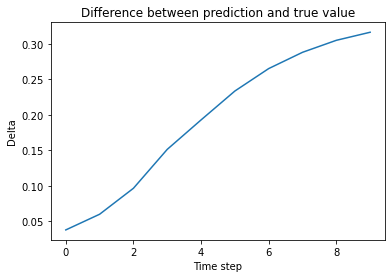

In [ ]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=3000
N_step_pred=10
print('Start_position=', start_position)
prediction(model,start_position,N_step_pred,state_history_norm_th)

In [ ]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=3000
N_step_pred=1000
print('Start_position=', start_position)
prediction(model,start_position,N_step_pred,state_history_norm_th)

## Model 2

In [ ]:
#CONV1
in_channel_1 = 1
Hin_ch_conv_1 = sample_points
Win_ch_conv_1 = 100

kH_conv_1 = 5
stH_conv_1 = 1
padH_conv_1 = 2

kW_conv_1 = 5
stW_conv_1 = 1
padW_conv_1 = 2

Hout_ch_conv_1 = (Hin_ch_conv_1+2*padH_conv_1-(kH_conv_1-1)-1)/stH_conv_1+1
Wout_ch_conv_1 = (Win_ch_conv_1+2*padW_conv_1-(kW_conv_1-1)-1)/stW_conv_1+1
out_channel_1 = 3


#MAXPOOL1
kH_pool_1= 2
stH_pool_1= 2

kW_pool_1= 2
stW_pool_1= 2

Hin_ch_conv_2 = (Hout_ch_conv_1 - kH_pool_1)/stH_pool_1 + 1
Win_ch_conv_2 = (Wout_ch_conv_1 - kW_pool_1)/stW_pool_1 + 1


#CONV2
in_channel_2 = out_channel_1

kH_conv_2 = 2
stH_conv_2 = 2
padH_conv_2 = 2

kW_conv_2 = 25
stW_conv_2 = 25
padW_conv_2 = 0

Hout_ch_conv_2 = (Hin_ch_conv_2+2*padH_conv_2-(kH_conv_2-1)-1)/stH_conv_2+1
Wout_ch_conv_2 = (Win_ch_conv_2+2*padW_conv_2-(kW_conv_2-1)-1)/stW_conv_2+1
out_channel_2 = 1


#MAXPOOL2

kH_pool_2= 2
stH_pool_2= 2

kW_pool_2= 2
stW_pool_2= 1

Hin_ch_conv_3 = (Hout_ch_conv_2 - kH_pool_2)/stH_pool_2 + 1
Win_ch_conv_3 = (Wout_ch_conv_2 - kW_pool_2)/stW_pool_2 + 1

in_lin = int(Hin_ch_conv_3)
hidden_lin1 = sample_points
hidden_lout1 = sample_points*2
out_lin = sample_points

model = th.nn.Sequential(
    th.nn.Conv2d(in_channel_1,out_channel_1,kernel_size=(kH_conv_1,kW_conv_1),stride=(stH_conv_1,stW_conv_1),padding=(padH_conv_1,padW_conv_1)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_1,kW_pool_1),stride=(stH_pool_1,stW_pool_1)),
    th.nn.Conv2d(in_channel_2,out_channel_2,kernel_size=(kH_conv_2,kW_conv_2),stride=(stH_conv_2,stW_conv_2),padding=(padH_conv_2,padW_conv_2)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_2,kW_pool_2),stride=(stH_pool_2,stW_pool_2)),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_lin1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_lin1,hidden_lout1),
    th.nn.Tanh(),
    th.nn.Linear(hidden_lout1,out_lin),
    th.nn.Tanh(),
)
                   

model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

In [ ]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [ ]:
model

In [ ]:
#TO SAVE THE MODEL

# Here we create a dictionnary to store what we need: 
# 1/ the epoch number
# 2/ the batch size
# 2/ the paramters of the model
# 3/ the paramters of the optimizer
# 4/ the loss function we used
tosave_data = {'epoch': epochs_counter,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv2d_model2_u3")

In [ ]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=200
N_step_pred=1000
print('Start_position=', start_position)
prediction(model,start_position,N_step_pred,state_history_norm_th)

In [ ]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=3000
N_step_pred=1000
print('Start_position=', start_position)
prediction(model,start_position,N_step_pred,state_history_norm_th)

## Model 3

In [12]:
#CONV1
in_channel_1 = 1
Hin_ch_conv_1 = sample_points
Win_ch_conv_1 = 100

kH_conv_1 = 4
stH_conv_1 = 1
padH_conv_1 = 2

kW_conv_1 = 4
stW_conv_1 = 3
padW_conv_1 = 3

Hout_ch_conv_1 = (Hin_ch_conv_1+2*padH_conv_1-(kH_conv_1-1)-1)/stH_conv_1+1
Wout_ch_conv_1 = (Win_ch_conv_1+2*padW_conv_1-(kW_conv_1-1)-1)/stW_conv_1+1
out_channel_1 = 3


#MAXPOOL1
kH_pool_1= 3
stH_pool_1= 1

kW_pool_1= 3
stW_pool_1= 2

Hin_ch_conv_2 = (Hout_ch_conv_1 - kH_pool_1)/stH_pool_1 + 1
Win_ch_conv_2 = (Wout_ch_conv_1 - kW_pool_1)/stW_pool_1 + 1




#CONV2
in_channel_2 = out_channel_1

kH_conv_2 = 4
stH_conv_2 = 1
padH_conv_2 = 1

kW_conv_2 = 5
stW_conv_2 = 4
padW_conv_2 = 0

Hout_ch_conv_2 = (Hin_ch_conv_2+2*padH_conv_2-(kH_conv_2-1)-1)/stH_conv_2+1
Wout_ch_conv_2 = (Win_ch_conv_2+2*padW_conv_2-(kW_conv_2-1)-1)/stW_conv_2+1
out_channel_2 = 1


#MAXPOOL2

kH_pool_2= 4
stH_pool_2= 1

kW_pool_2= 4
stW_pool_2= 1

Hin_ch_conv_3 = (Hout_ch_conv_2 - kH_pool_2)/stH_pool_2 + 1
Win_ch_conv_3 = (Wout_ch_conv_2 - kW_pool_2)/stW_pool_2 + 1


#Linear

in_lin = int(Hin_ch_conv_3)
hidden_lin1 = sample_points
hidden_lout1 = sample_points*2
out_lin = sample_points

model = th.nn.Sequential(
    th.nn.Conv2d(in_channel_1,out_channel_1,kernel_size=(kH_conv_1,kW_conv_1),stride=(stH_conv_1,stW_conv_1),padding=(padH_conv_1,padW_conv_1)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_1,kW_pool_1),stride=(stH_pool_1,stW_pool_1)),
    th.nn.Conv2d(in_channel_2,out_channel_2,kernel_size=(kH_conv_2,kW_conv_2),stride=(stH_conv_2,stW_conv_2),padding=(padH_conv_2,padW_conv_2)),
    th.nn.LeakyReLU(),
    th.nn.MaxPool2d(kernel_size=(kH_pool_2,kW_pool_2),stride=(stH_pool_2,stW_pool_2)),
    th.nn.Flatten(),
    th.nn.Linear(in_lin,hidden_lin1),
    th.nn.LeakyReLU(),
    th.nn.Linear(hidden_lin1,hidden_lout1),
    th.nn.Tanh(),
    th.nn.Linear(hidden_lout1,out_lin),
    th.nn.Tanh(),
)
                   

model.double()
model.cuda()
optimizer=th.optim.Adam(model.parameters(),lr=1e-5)
loss_fn=th.nn.MSELoss()

Epoch	Train Loss	Valid Loss
0	 0.00034..	 0.00035..
1	 0.00034..	 0.00035..
2	 0.00034..	 0.00034..
3	 0.00034..	 0.00035..
4	 0.00034..	 0.00034..
5	 0.00034..	 0.00035..
6	 0.00034..	 0.00034..
7	 0.00034..	 0.00034..
8	 0.00034..	 0.00034..
9	 0.00034..	 0.00034..
10	 0.00034..	 0.00034..
11	 0.00034..	 0.00034..
12	 0.00034..	 0.00034..
13	 0.00034..	 0.00034..
14	 0.00034..	 0.00034..
15	 0.00034..	 0.00034..
16	 0.00034..	 0.00034..
17	 0.00034..	 0.00034..
18	 0.00034..	 0.00034..
19	 0.00034..	 0.00034..
20	 0.00033..	 0.00034..
21	 0.00033..	 0.00034..
22	 0.00033..	 0.00034..
23	 0.00033..	 0.00033..
24	 0.00033..	 0.00033..
25	 0.00033..	 0.00033..
26	 0.00033..	 0.00033..
27	 0.00033..	 0.00033..
28	 0.00033..	 0.00033..
29	 0.00033..	 0.00033..
30	 0.00033..	 0.00033..
31	 0.00033..	 0.00033..
32	 0.00033..	 0.00033..
33	 0.00033..	 0.00033..
34	 0.00033..	 0.00033..
35	 0.00033..	 0.00033..
36	 0.00033..	 0.00033..
37	 0.00033..	 0.00033..
38	 0.00033..	 0.00033..
39	 0.0

319	 0.00024..	 0.00024..
320	 0.00024..	 0.00024..
321	 0.00024..	 0.00024..
322	 0.00024..	 0.00024..
323	 0.00024..	 0.00024..
324	 0.00024..	 0.00024..
325	 0.00024..	 0.00024..
326	 0.00024..	 0.00024..
327	 0.00024..	 0.00024..
328	 0.00024..	 0.00024..
329	 0.00024..	 0.00024..
330	 0.00024..	 0.00024..
331	 0.00024..	 0.00024..
332	 0.00024..	 0.00024..
333	 0.00024..	 0.00024..
334	 0.00024..	 0.00024..
335	 0.00024..	 0.00024..
336	 0.00024..	 0.00024..
337	 0.00024..	 0.00024..
338	 0.00024..	 0.00024..
339	 0.00024..	 0.00024..
340	 0.00024..	 0.00024..
341	 0.00024..	 0.00024..
342	 0.00024..	 0.00024..
343	 0.00024..	 0.00024..
344	 0.00024..	 0.00024..
345	 0.00024..	 0.00024..
346	 0.00024..	 0.00024..
347	 0.00024..	 0.00024..
348	 0.00024..	 0.00024..
349	 0.00024..	 0.00024..
350	 0.00024..	 0.00024..
351	 0.00024..	 0.00024..
352	 0.00024..	 0.00024..
353	 0.00024..	 0.00024..
354	 0.00024..	 0.00024..
355	 0.00023..	 0.00024..
356	 0.00023..	 0.00024..
357	 0.00023

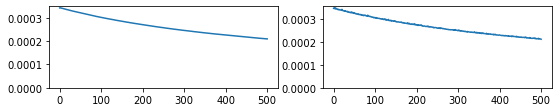

In [ ]:
epochs_counter=500
batch_size=64
train_losses, valid_losses = train(model,X_train_th,X_valid_th,Y_train_th,Y_valid_th,epochs=epochs_counter,batch_size=batch_size)

In [ ]:
model

Sequential(
  (0): Conv2d(1, 3, kernel_size=(4, 4), stride=(1, 3), padding=(2, 3))
  (1): LeakyReLU(negative_slope=0.01)
  (2): MaxPool2d(kernel_size=(3, 3), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(3, 1, kernel_size=(4, 5), stride=(1, 4), padding=(1, 0))
  (4): LeakyReLU(negative_slope=0.01)
  (5): MaxPool2d(kernel_size=(4, 4), stride=(1, 1), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=59, out_features=64, bias=True)
  (8): LeakyReLU(negative_slope=0.01)
  (9): Linear(in_features=64, out_features=128, bias=True)
  (10): Tanh()
  (11): Linear(in_features=128, out_features=64, bias=True)
  (12): Tanh()
)

Start_position= 40012
The true solution:


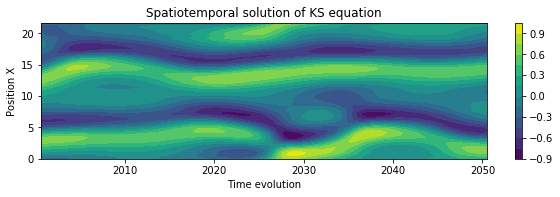

The model solution:


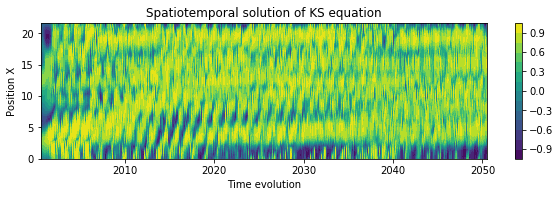

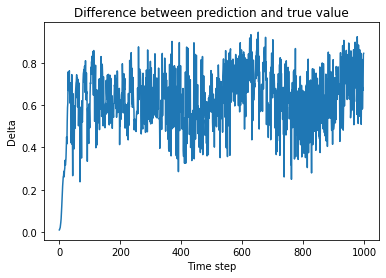

In [41]:
size_conv_time=100
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=40012
N_step_pred=1000
print('Start_position=', start_position)
prediction(model,start_position,N_step_pred,state_history_norm_th)

Start_position= 3000
The true solution:


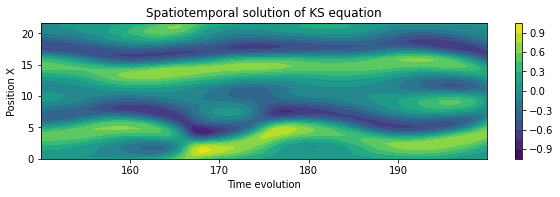

The model solution:


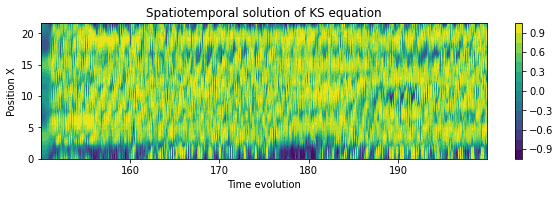

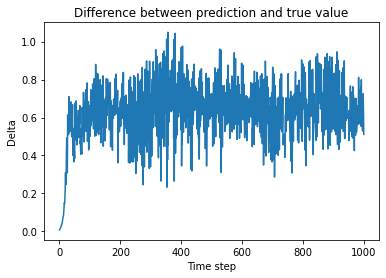

In [ ]:
state_history_norm_th = th.from_numpy(state_history_norm).cuda()
#state_history_norm_th = state_history_norm_th.unsqueeze(0)
start_position=3000
N_step_pred=1000
print('Start_position=', start_position)
prediction(model,start_position,N_step_pred,state_history_norm_th)

In [19]:
state_history.shape

(200001, 64)

In [ ]:
#TO SAVE THE MODEL

tosave_data = {'model': model,
               'epoch': epoch,
               'batch_size': batch_size,
               'model_state_dict': model.state_dict(),
               'optimizer_state_dict': optimizer.state_dict(),
               'loss': loss_fn,
               'training loss': train_losses,
               'valid loss': valid_losses,}
# Write a pickle file using pytorch 
th.save(tosave_data, "modelcv2d_model3_u3")

In [14]:
cd ../ks-simulator/Models/

C:\Users\Callado\Documents\GitHub\Research-internship\Simulators\ks-simulator\Models


In [15]:
name = "modelcv2d_model3_u3"
checkpoint = th.load(name)
# restore the model and optimizer states: 
model = checkpoint['model']
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']
loss_fn=checkpoint['loss']
train_losses=checkpoint['training loss']
valid_losses=checkpoint['valid loss']